# Помощь HR-аналитикам

**Вводные:**    
HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. В этом HR-аналитикам пригодится машинное обучение, с помощью которого получится быстрее и точнее отвечать на вопросы бизнеса.
Компания предоставила данные с характеристиками сотрудников компании:    
- уровень удовлетворённости сотрудника работой в компании. Информация получена из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается **доля их удовлетворённости от 0 до 1**:
  - 0 — совершенно неудовлетворён,
  - 1 — полностью удовлетворён.*

# Задача 1. Предсказание уровня удовлетворенности сотрудника

**Цель:** построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика.

**Исходные данные наборов:**
- ***тренировочной выборки*** train_job_satisfaction_rate,
- ***тестовой выборки (входные признаки)*** test_features,
- ***тестовой выборки (целевой признак)*** test_target_job_satisfaction_rate:
    - **id** — уникальный идентификатор сотрудника;
    - **dept** — отдел, в котором работает сотрудник;
    - **level** — уровень занимаемой должности;
    - **workload** — уровень загруженности сотрудника;
    - **employment_years** — длительность работы в компании (в годах);
    - **last_year_promo** — показывает, было ли повышение за последний год;
    - **last_year_violations** — показывает, нарушал ли сотрудник трудовой договор за последний год;
    - **supervisor_evaluation** — оценка качества работы сотрудника, которую дал руководитель;
    - **salary** — ежемесячная зарплата сотрудника;
    - **job_satisfaction_rate** — уровень удовлетворённости сотрудника работой в компании, целевой признак.     

In [1]:
!pip install shap
!pip install scikit-learn==1.1.3
!pip install phik
!pip install matplotlib==3.3.4
!pip install plotly==5.4.0
!pip install seaborn==0.11.1

# 1.1 Загрузка данных

In [2]:
# Импортируем все нужные библиотеки и инструменты
import pandas as pd
import seaborn as sns
import numpy  as np
import shap
import phik

from matplotlib import pyplot as plt
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.dummy import DummyClassifier

from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    RandomizedSearchCV
)
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    MinMaxScaler,
    LabelEncoder
)
from sklearn.metrics import (
    confusion_matrix,
    roc_auc_score,
    f1_score,
    make_scorer
)

# зададим параметры окна вывода графиков
plt.rcParams["figure.figsize"] = (12,9)

In [3]:
# загружаем входные признаки тестовой выборки test_features.csv
try:
    df_X_test = pd.read_csv('с:/users/bny_7/datasets/test_features.csv', sep=',', decimal='.')
except:
    df_X_test = pd.read_csv('/datasets/test_features.csv', sep=',', decimal='.')
    
# загружаем тренировочную выборку train_job_satisfaction_rate.csv
try:
    df_X_train = pd.read_csv('с:/users/bny_7/datasets/train_job_satisfaction_rate.csv', sep=',', decimal='.')
except:
    df_X_train = pd.read_csv('/datasets/train_job_satisfaction_rate.csv', sep=',', decimal='.')
    
# загружаем целевой признак тестовой выборки test_target_job_satisfaction_rate.csv
try:
    df_y_test = pd.read_csv('с:/users/bny_7/datasets/test_target_job_satisfaction_rate.csv', sep=',', decimal='.')
except:
    df_y_test = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv', sep=',', decimal='.')

In [4]:
# выводим на экран входные признаки тестовой выборки
display(df_X_test.head())

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


In [5]:
# выводим на экран тренировочную выборку
display(df_X_train.head())

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


In [6]:
# выводим на экран целевой признак тестовой выборки
display(df_y_test.head())

,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


**Вывод после загрузки:**     
Данные прочитаны, ошибок нет, переходим к их предобработке.

# 1.2 Предобработка данных

In [7]:
# выведем описание входных признаков тестовых данных
display(df_X_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


None

In [8]:
# подсчитаем количество дубликатов
display(df_X_test.duplicated().sum())

# проанализируем строковые данные, чтобы проверить орфографию
for i in df_X_test.select_dtypes('object').columns:
    display(df_X_test[i].value_counts())

0

sales         763
technology    455
marketing     279
purchasing    273
hr            227
                1
Name: dept, dtype: int64

junior    974
middle    854
sinior    171
Name: level, dtype: int64

medium    1043
low        593
high       363
             1
Name: workload, dtype: int64

no     1937
yes      63
Name: last_year_promo, dtype: int64

no     1738
yes     262
Name: last_year_violations, dtype: int64

В наборе **df_X_test**:     
- 2000 записей,
- формат данных корректный,
- пропуски есть в полях dept (1998 объектов) и level (1999 объектов). Пропусков мало.  
- дубликаты отсутствуют,
- в строковых полях с категориальными данными повторов и ошибок нет.
Пропуски в полях с категориальными данными устраним на этапе формирования пайплайна построения модели.

In [9]:
# выводим описание тренировочной выборки
display(df_X_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


None

In [10]:
# подсчитаем количество дубликатов
display(df_X_train.duplicated().sum())

# проанализируем строковые данные, чтобы проверить орфографию
for i in df_X_train.select_dtypes('object').columns:
    display(df_X_train[i].value_counts())

0

sales         1512
technology     866
purchasing     610
marketing      550
hr             456
Name: dept, dtype: int64

junior    1894
middle    1744
sinior     358
Name: level, dtype: int64

medium    2066
low       1200
high       734
Name: workload, dtype: int64

no     3880
yes     120
Name: last_year_promo, dtype: int64

no     3441
yes     559
Name: last_year_violations, dtype: int64

В наборе **df_X_train**:     
- 4000 записей,
- формат данных корректный,
- пропуски также наблюдаются в полях dept (3994 объекта) и level (3996 объектов). Пропусков мало.   
- дубликаты отсутствуют,
- орфографических ошибок в строковых данных нет.

Как и в предыдущем случае, поля содержат категориальные данные, так что сможем заполнить их в пайплайне построения модели.

In [11]:
# выводим описание целевого признака тестовой выборки
display(df_y_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


None

In [12]:
# подсчитаем количество дубликатов
display(df_y_test.duplicated().sum())

0

В наборе **df_y_test**:    
- 2000 записей,
- формат данных корректный,
- пропусков нет,
- дублей нет.

**Вывод после предобработки данных**:    
Данные изучены, форматы корректные, дубликаты отсутствуют, орфографические ошибки отсутствуют, пропуски есть, но их очень мало.     
В нашем наборе данных 8 категориальных полей и один с непрерывными данными. Значит, лучшую оценку должна дать модель дерева решений.     
Пропуски в категориальных данных мы исправим при построении пайплайна модели.

# 1.3 Исследовательский анализ данных

In [13]:
# сделаем из id индексное поле и исследуем данные набора df_X_test
df_X_test = df_X_test.set_index('id')
display(df_X_test.describe())

,employment_years,supervisor_evaluation,salary
count,2000.000000,2000.000000,2000.000000
mean,3.666500,3.526500,34066.800000
std,2.537222,0.996892,15398.436729
min,1.000000,1.000000,12000.000000
25%,1.000000,3.000000,22800.000000
50%,3.000000,4.000000,30000.000000
75%,6.000000,4.000000,43200.000000
max,10.000000,5.000000,96000.000000


Явные выбросы в числовых данных отсутствуют.

Распределение имеет явное смещение. Медианное значение зарплаты 30тыр., а максимальное значение составляет 96тыр.    
Видимо, зарплаты у сотрудников распределяются неравномерно.

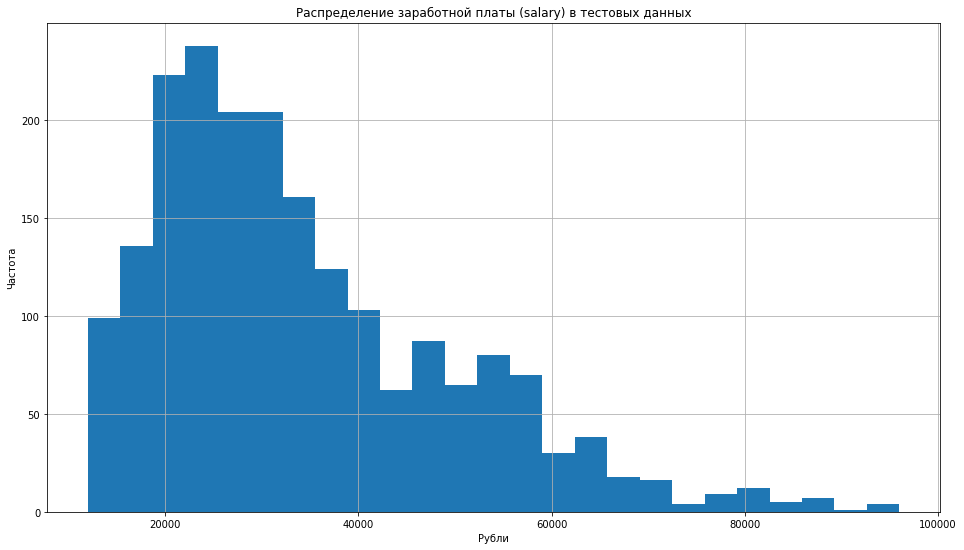

In [14]:
# построим гистограмму для поля с зарплатой (salary)
plt.figure(figsize=(16,9))
df_X_test['salary'].hist(bins=25)
plt.title('Распределение заработной платы (salary) в тестовых данных')
plt.xlabel('Рубли')
plt.ylabel('Частота')
plt.show()

In [15]:
# подсчитаем, какое количество сотрудников получает зарплату выше верхнего предела нормального распределения
display(df_X_test[df_X_test['salary']>=43200]['salary'].count())

508

Количество "выбросов" существенное (1/4 от объема данных: 500 против 2000), может наблюдаться ошибка в прогнозах для этой категории сотрудников.    
Необходимо проверить, соблюдается ли подобная диспропорция на тестовых данных.

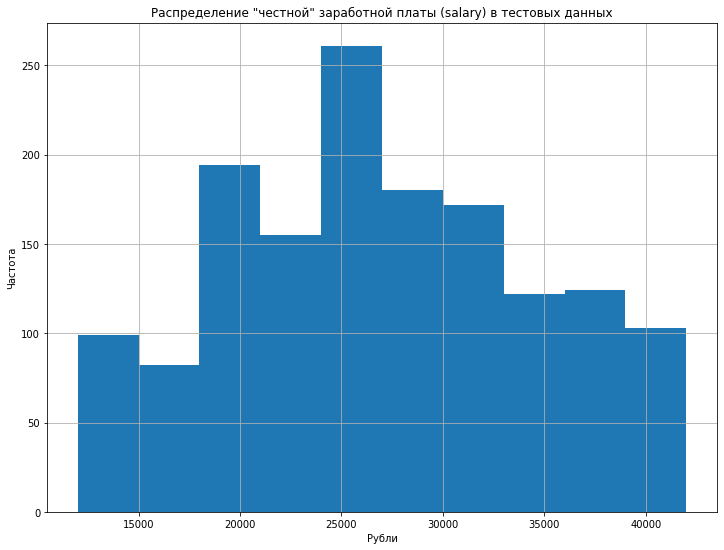

In [16]:
# отобразим данные на гистограмме
df_X_test[df_X_test['salary']<43200]['salary'].hist(bins=10)
plt.title('Распределение "честной" заработной платы (salary) в тестовых данных')
plt.xlabel('Рубли')
plt.ylabel('Частота')
plt.show()

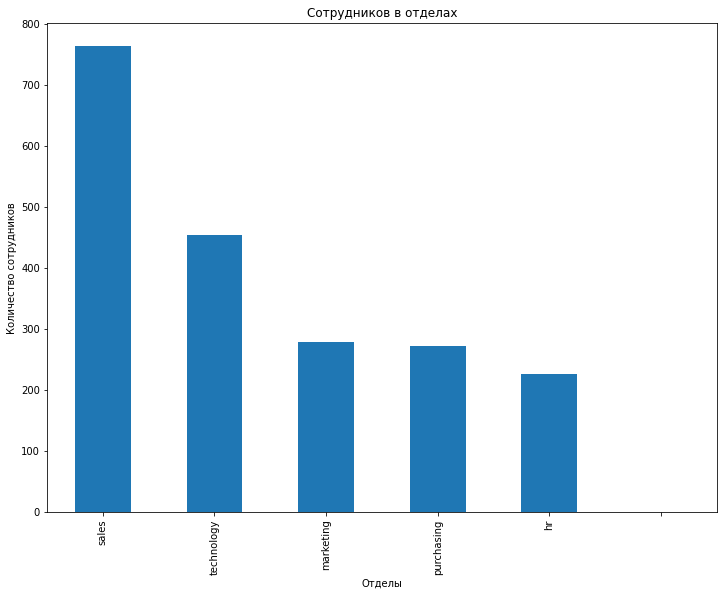

In [17]:
## посмотрим на распределение категорий в должностях и отделах
df_X_test['dept'].value_counts().plot(kind='bar')
plt.title('Сотрудников в отделах')
plt.xlabel('Отделы')
plt.ylabel('Количество сотрудников')
plt.show()

Большинство сотрудников работает в отделе продаж. Почти одинаковое количество представителей отделов маркетинга, закупок и HR. Наблюдается дисбаланс классов.

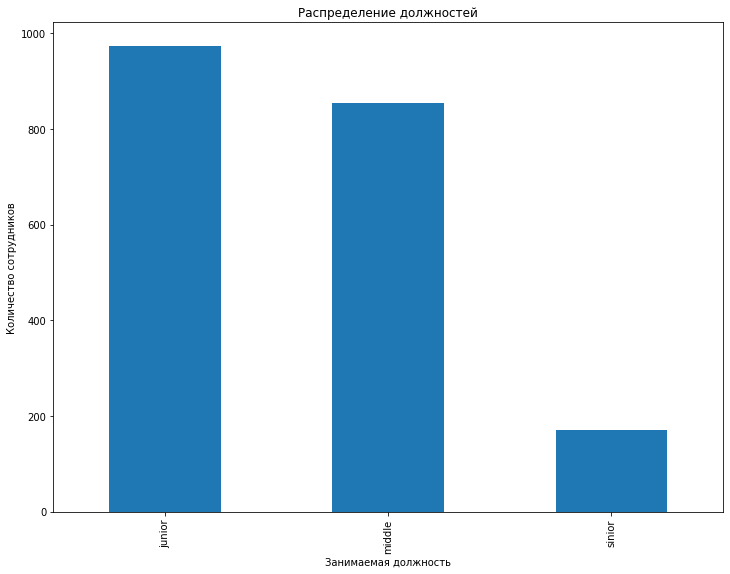

In [18]:
## посмотрим на распределение уровня занимаемой должности в компании
df_X_test['level'].value_counts().plot(kind='bar')
plt.title('Распределение должностей')
plt.xlabel('Занимаемая должность')
plt.ylabel('Количество сотрудников')
plt.show()

Теперь понятно, откуда такой перекос в зарплатах: большинство сотрудников, которые участвовали в опросе, занимают нижние и средние позиции. Здесь тоже наблюдается дисбаланс классов.

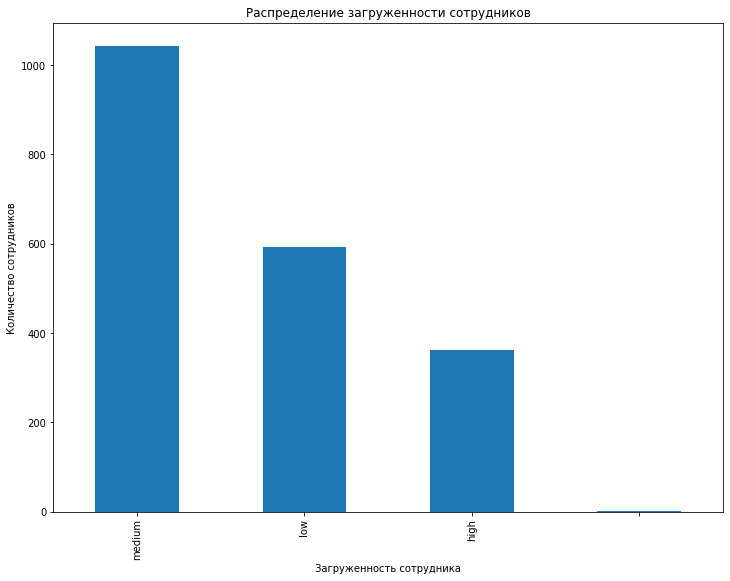

In [19]:
## посмотрим на распределение уровня загруженности сотрудников
df_X_test['workload'].value_counts().plot(kind='bar')
plt.title('Распределение загруженности сотрудников')
plt.xlabel('Загруженность сотрудника')
plt.ylabel('Количество сотрудников')
plt.show()

И здесь видим дисбаланс классов: больше сотрудников со средней загруженностью.

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


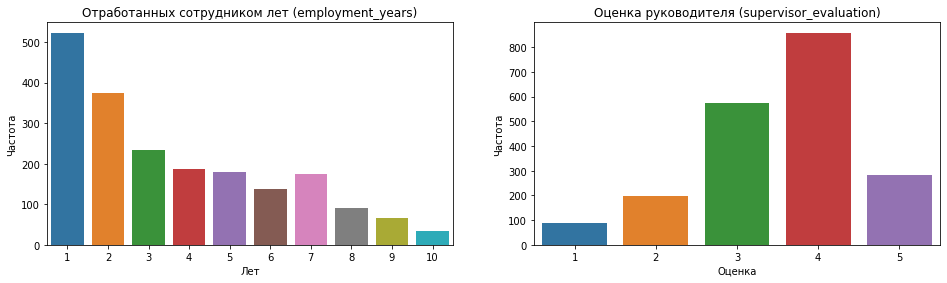

In [20]:
# исследуем поле employment_years
plt.figure(figsize=(16,9))
plt.subplot(2,2,1)
sns.countplot(df_X_test['employment_years'])
plt.title('Отработанных сотрудником лет (employment_years)')
plt.xlabel('Лет')
plt.ylabel('Частота')
# исследуем поле supervisor_evaluation 
plt.subplot(2,2,2)
sns.countplot(df_X_test['supervisor_evaluation'])
plt.title('Оценка руководителя (supervisor_evaluation)')
plt.xlabel('Оценка')
plt.ylabel('Частота')
plt.show()

В компании «Работа с заботой» много молодых сотрудников, которые работают менее 1-2 года, максимальное количество отработанных в компании лет составляет 10. По оценке руководителей откровенно плохих сотрудников мало, много середнячков (3) и хорошистов (4). Немало и сотрудников, которыми очень довольны руководители.

In [21]:
# сделаем из id индексное поле и исследуем данные набора df_X_train
df_X_train = df_X_train.set_index('id')
display(df_X_train.describe())

,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,4000.000000,4000.000000,4000.000000,4000.000000
mean,3.718500,3.476500,33926.700000,0.533995
std,2.542513,1.008812,14900.703838,0.225327
min,1.000000,1.000000,12000.000000,0.030000
25%,2.000000,3.000000,22800.000000,0.360000
50%,3.000000,4.000000,30000.000000,0.560000
75%,6.000000,4.000000,43200.000000,0.710000
max,10.000000,5.000000,98400.000000,1.000000


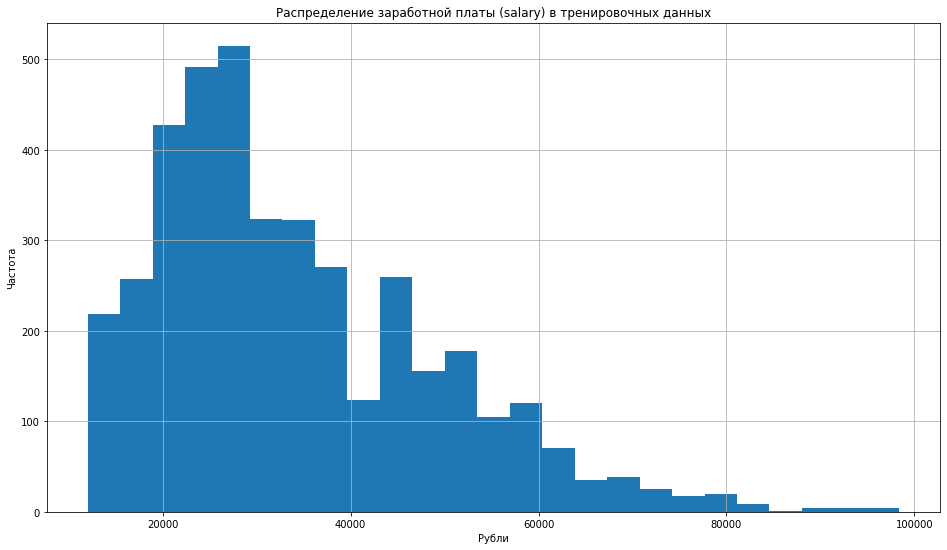

In [22]:
# построим гистограмму для поля с зарплатой (salary)
plt.figure(figsize=(16,9))
df_X_train['salary'].hist(bins=25)
plt.title('Распределение заработной платы (salary) в тренировочных данных')
plt.xlabel('Рубли')
plt.ylabel('Частота')
plt.show()

In [23]:
# подсчитаем, какое количество сотрудников получает зарплату выше верхнего предела нормального распределения
display(df_X_train[df_X_train['salary']>=43200]['salary'].count())

1049

Выше верхнего порога также лежит 1/4 от объема данных тренировочной выборки (1000 против 4000). Квартили тренировочной и тестовой  выборок в данных о зарплате одинаковы, так что искажений в решениях модели быть не должно. 

In [24]:
# сделаем из id индексное поле и исследуем данные набора df_y_test
df_y_test = df_y_test.set_index('id')
display(df_y_test.describe())

,job_satisfaction_rate
count,2000.00000
mean,0.54878
std,0.22011
min,0.03000
25%,0.38000
50%,0.58000
75%,0.72000
max,1.00000


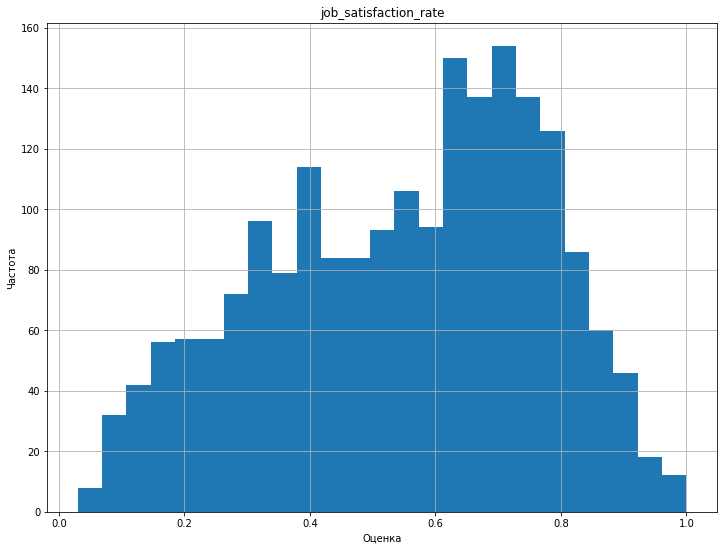

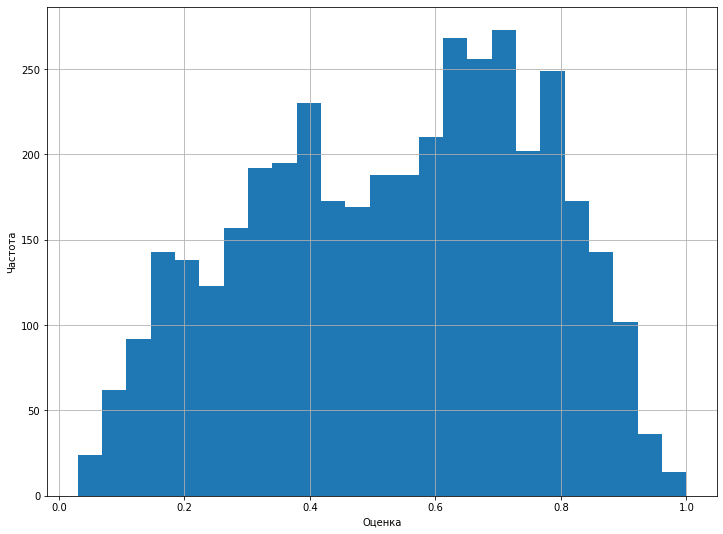

In [25]:
# рассмотрим распределение целевого признака в тестовой выборке и тренировочной
df_y_test.hist(bins=25)
plt.title=('Удовлетворенность сотрудника в тестовой выборке')
plt.xlabel('Оценка')
plt.ylabel('Частота')
plt.show()
df_X_train['job_satisfaction_rate'].hist(bins=25)
plt.title=('Удовлетворенность сотрудника в тренировочной выборке')
plt.xlabel('Оценка')
plt.ylabel('Частота')
plt.show()

Распределения целевого признака похожи для тестовой и тренировочной выборок. Близко к нормальному со смещением вправо.

In [26]:
# поскольку у нас много категориальных данных, то построим матрицу корреляции на тренировочных данных методом phik_matrix.
# задаем столбцы с непрерывными признаками и рассчитываем матрицу
interval_cols = ['salary','job_satisfaction_rate']
corr_matrix_train = df_X_train.phik_matrix(interval_cols = interval_cols)

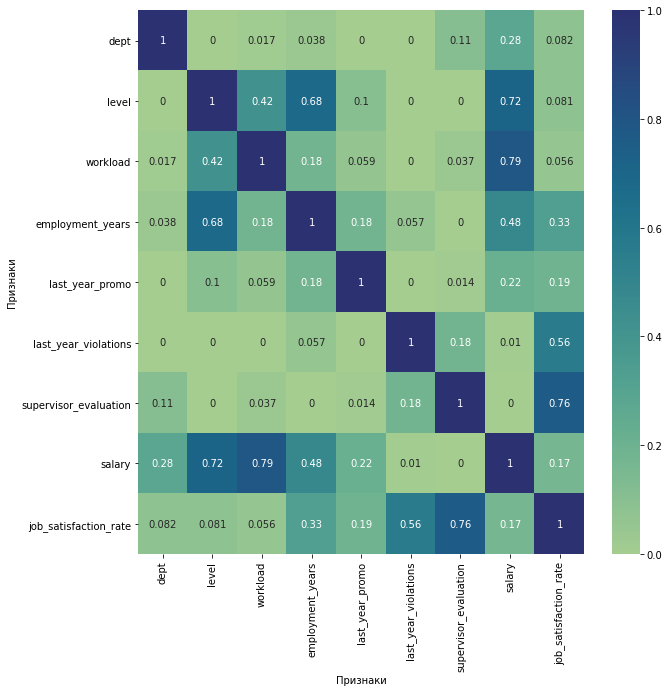

In [27]:
# строим тепловую карту для анализа матрицы корреляции набора df_X_train
plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix_train, annot=True, cmap='crest')
plt.title=('Матрица корреляции')
plt.xlabel('Признаки')
plt.ylabel('Признаки')
plt.show()

На наш целевой признак влияют следующие признаки:
- оценки руководителя (0.73: *усилилось до 0.76*),
- нарушений трудового договора за последний год (0.59: *ослабла до 0.56*),
- повышения за последний год (0.43: *сильно ослабла до 0.19*),
- количества отработанных лет (0.33: *сохранилось*),
- зарплаты (0.22: *ослабла до 0.17*).

In [28]:
# проверим зависимости на тестовой выборке, предварительно соединенной с целевым признаком
df = df_X_test.join(df_y_test)
display(df.head())
corr_matrix_test = df.phik_matrix(interval_cols = interval_cols)

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800,0.79
686555,hr,junior,medium,1,no,no,4,30000,0.72
467458,sales,middle,low,5,no,no,4,19200,0.64
418655,sales,middle,low,6,no,no,4,19200,0.60
789145,hr,middle,medium,5,no,no,5,40800,0.75


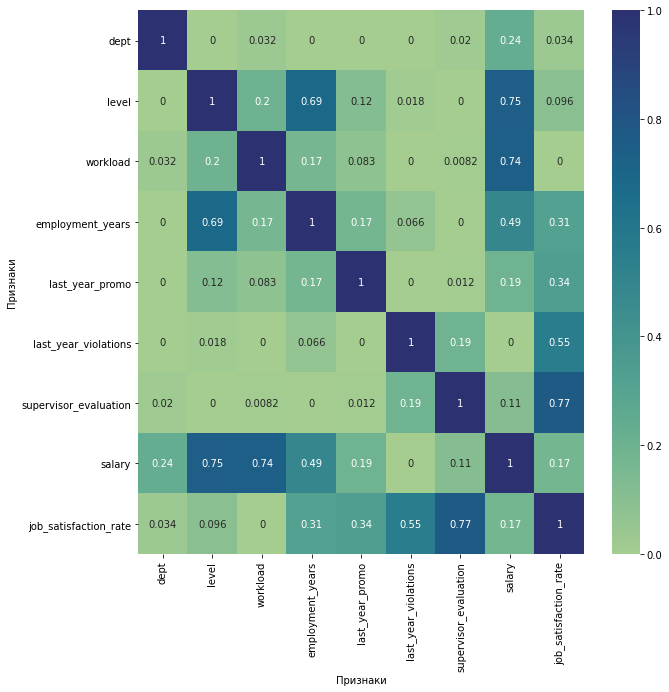

In [29]:
# строим тепловую карту для анализа матрицы корреляции набора df_X_test.join(df_y_test)
plt.figure(figsize=(10, 10))
sns.heatmap(corr_matrix_test, annot=True, cmap='crest')
plt.suptitle=('Матрица корреляции')
plt.xlabel('Признаки')
plt.ylabel('Признаки')
plt.show()

На тестовой выборке наш целевой признак показывает незначительное отличие зависимости от входных признаков в сравнении с тренировочной выборкой по 4 из выбранных признаков:
- **supervisor_evaluation - оценки руководителя** (0.74 против 0.73: 0.77 против 0.76),
- **last_year_violations - нарушений трудового договора за последний год** (0.58 против 0.59: 0.55 против 0.56),
- **last_year_promo - повышения за последний год** (0.53 против 0.43: 0.34 против 0.19),
- **employment_years - количества отработанных лет** (0.34 против 0.33: 0.31 против 0.33),
- **salary - зарплаты** (0.20 против 0.22: 0.17 против 0.17).

Разница по показателю Повышения за последний год (0.34 против 0.19) существенная. Получается, что в тестовую выборку попало больше повышенных в должности за последний год.    

**Вывод по результатам иссследования данных**:   
- распределение заработной платы имеет явное смещение. Медианное значение зарплаты 30тыр., а максимальное значение составляет 96тыр. За верхним порогом лежит 1/4 от всего объема данных, но пропорция соблюдается для тестовой и тренировочной выборок;  
- в компании «Работа с заботой» много молодых сотрудников, которые работают менее 1-2 года;
- максимальное количество отработанных в компании лет составляет 10;
- по оценке руководителей откровенно плохих сотрудников мало, много середнячков (3) и хорошистов (4). Немало и сотрудников, которыми очень довольны руководители.
- распределения целевого признака (удовлетворенность условиями труда) похожи для тестовой и тренировочной выборок, близки к нормальному со смещением вправо;
- большинство сотрудников работает в отделе продаж. Почти одинаковое количество представителей отделов маркетинга, закупок и HR. Присутствует дисбаланс классов.
- большинство сотрудников, которые участвовали в опросе, занимают нижние и средние позиции. Присутствует дисбаланс классов.
- большинство сотрудников имеют среднюю загруженность. Присутствует дисбаланс классов.
- других выбросов и аномалий в наших данных нет;
- на наш целевой признак влияют следующие признаки:
    - оценки руководителя (0.73),
    - нарушений трудового договора за последний год (0.59),
    - повышения за последний год (0.43),
    - количества отработанных лет (0.33),
    - зарплаты (0.22).

# 1.4 Подготовка данных

In [30]:
# объединим тестовые данные по id, а затем разделим их для проверки модели
df_test_merge = df_X_test.sort_values('id').join(df_y_test, on='id')

# задаем константу
RANDOM_STATE = 42

# делим тренировочную и тестовую выборки на 2 датасета - входные признаки и целевой признак
X_train = df_X_train.drop(['job_satisfaction_rate'], axis=1)
y_train = df_X_train['job_satisfaction_rate'] 
X_test = df_test_merge.drop('job_satisfaction_rate', axis=1)
y_test = df_test_merge['job_satisfaction_rate']


In [31]:
# создаём списки с названиями признаков, используем 3 кодировщика
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']
ord_columns = ['level','workload']
num_columns = ['employment_years','supervisor_evaluation', 'salary']

In [32]:
# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
ohe_pipe = Pipeline(
    [
     ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False))
    ]
    )

In [33]:
# создаём пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков и Ordinal-кодирование
ord_pipe = Pipeline(
    [
     ('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories= [
                    ['junior', 'middle', 'sinior'],
                    ['low', 'medium', 'high']
                ],
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

In [34]:
# создаём общий пайплайн для подготовки данных
data_preprocessor_rate = ColumnTransformer(transformers=
    [('onehot', ohe_pipe, ohe_columns),
     ('ordinal', ord_pipe, ord_columns),
     ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

In [35]:
# создаём итоговый пайплайн: подготовка данных и модель
pipe_final_rate = Pipeline([
    ('preprocessor', data_preprocessor_rate),
    ('models', LinearRegression())
])

# 1.5 Обучение моделей

Поскольку у нас задача мультиклассовой классификации, то обучим следующие 2 модели:
- DecisionTreeRegressor(),
- LinearRegression().

In [36]:
# создадим функцию для вычисления оценки SMAPE:
def smape(y_true, y_pred):
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))
   
smape_scorer = make_scorer(score_func=smape, greater_is_better=False)

In [37]:
param_grid_rate = [

    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(5, 15),
        'models__max_features': range(5, 15),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

Мы решаем задачу мультиклассовой классификации и наша задача: научиться максимально правильно определять целевой признак 'Уровень удовлетворённости сотрудника работой'.    
Для отбора лучшей модели будем использовать оценку **smape**.

In [38]:
# запускаем поиск лучшей модели и ее параметров и обучаем ее на тренировочной выборке
randomized_search_rate = RandomizedSearchCV(
    pipe_final_rate, 
    param_grid_rate, 
    cv=5,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    scoring=smape_scorer
)

In [39]:
randomized_search_rate.fit(X_train, y_train)

rs_rate = randomized_search_rate.best_estimator_

In [40]:
# выводим на экран параметры лучшей модели на тренировочных данных
print('Лучшая модель и её параметры:\n\n', randomized_search_rate.best_estimator_)
print (f'Метрика SMAPE лучшей модели, полученная кросс-валидацией: {randomized_search_rate.best_score_: .2f}')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ordinal',
                            

Путем подбора гиперпараметров для дерева решений мы достигли значения метрики **SMAPE** на тренировочной выборке: **15.01**.    

**Параметры лучшей модели**: DecisionTreeRegressor(max_depth=13, max_features=13, random_state=42)

In [41]:
# проверяем работу модели на тестовой выборке
# рассчитываем прогноз на тестовых данных
y_test_pred = randomized_search_rate.predict(X_test)

# выводим значение метрики SMAPE для тестовых данных
print(f'Метрика SMAPE на тестовой выборке:', round(smape(y_test, y_test_pred),2))

Метрика SMAPE на тестовой выборке: 14.28


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Оценим важность признаков для найденной модели 

In [42]:
# формируем тренировочную выборку, используя полученную модель
X_train_new_rate = data_preprocessor_rate.fit_transform(X_train)

# формируем тестовую выборку, используя полученную модель
X_test_new_rate = data_preprocessor_rate.transform(X_test)

# Создаем массив новых имен столбцов
feature_names_rate = data_preprocessor_rate.get_feature_names_out()

# Фильтруем датафрейм по списку полей, полученных после кодирования
X_test_new_rate = pd.DataFrame(X_test_new_rate, columns=feature_names_rate)

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [43]:
# инициализируем селектор и модель
selector_rate = SelectKBest(f_classif)

# обучим SelectKBest
selector_rate.fit(X_train_new_rate, y_train)

SelectKBest()

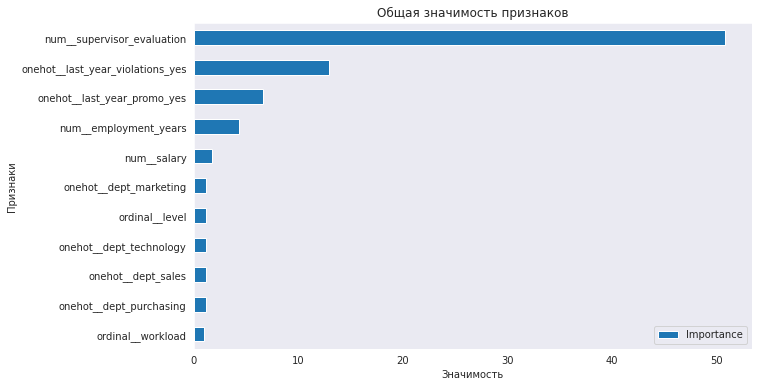

In [44]:
# отложим значения оценок для каждого признака на графике
feature_importance = pd.DataFrame({'Feature': feature_names_rate, 'Importance': selector_rate.scores_})
feature_importance = feature_importance.sort_values('Importance', ascending= True)
ax = sns.set_style('dark')
ax = feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))
ax.set_title('Общая значимость признаков')
ax.set_xlabel("Значимость")
ax.set_ylabel("Признаки")
plt.show()

# 1.6 Оформление выводов

**Вывод по результатам построения модели**:   

Подобранные гиперпараметры помогли создать модель, для которая рассчитанная метрика **SMAPE = 14.28** на тестовой выборке, что соответствует условиям задачи.     

Как мы и предполагали вначале, когда подсчитали количество категориальных и непрерывных данных (8:1), модель дерева решений показала лучшие результаты, поэтому в основном мы работали с подбором ее гиперпараметров.      

По результатам оценки важности признаков выявлены 2, которые сильно влияют на оценку отношения сотрудника:    
- **supervisor_evaluation** — оценка качества работы сотрудника руководителем,
- **last_year_violations** - нарушал ли сотрудник трудовой договор за последний год.   

Это же нам показывала и матрица корреляции.

# Задача 2. Предсказание увольнения сотрудника

**Цель**: построить модель, которая сможет предсказать увольнение сотрудника из компании.

**Исходные данные наборов**:

тренировочной выборки **train_quit**,
тестовой выборки (входные признаки) **test_features**,
тестовой выборки (целевой признак) **test_target_quit**:
- **id** — уникальный идентификатор сотрудника;
- **dept** — отдел, в котором работает сотрудник;
- **level** — уровень занимаемой должности;
- **workload** — уровень загруженности сотрудника;
- **employment_years** — длительность работы в компании (в годах);
- **last_year_promo** — показывает, было ли повышение за последний год;
- **last_year_violations** — показывает, нарушал ли сотрудник трудовой договор за последний год;
- **supervisor_evaluation** — оценка качества работы сотрудника, которую дал руководитель;
- **salary** — ежемесячная зарплата сотрудника;
- **test_target_quit** — целевой признак - увольнение сотрудника.

# 2.1 Загружаем данные

In [45]:
# загружаем тренировочную выборку train_quit.csv
try:
    quit_X_train = pd.read_csv('с:/users/bny_7/datasets/train_quit.csv', sep=',', decimal='.')
except:
    quit_X_train = pd.read_csv('/datasets/train_quit.csv', sep=',', decimal='.')
    
# загружаем целевой признак тестовой выборки test_target_quit.csv
try:
    quit_y_test = pd.read_csv('с:/users/bny_7/datasets/test_target_quit.csv', sep=',', decimal='.')
except:
    quit_y_test = pd.read_csv('/datasets/test_target_quit.csv', sep=',', decimal='.')

In [46]:
# проверяем загрузку данных
display(quit_X_train.head())

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


In [47]:
# проверяем загрузку данных
display(quit_y_test.head())

,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


**Вывод**: данные загружены, все в порядке.

# 2.2 Предобработка данных

In [48]:
# посмотрим на состав тренировочных данных
display(quit_X_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


None

In [49]:
# подсчитаем количество дубликатов в тренировочных данных
display(quit_X_train.duplicated().sum())

# проанализируем строковые данные, чтобы проверить орфографию
for i in quit_X_train.select_dtypes('object').columns:
    display(quit_X_train[i].value_counts())

0

sales         1438
technology     928
purchasing     588
marketing      582
hr             464
Name: dept, dtype: int64

junior    1949
middle    1694
sinior     357
Name: level, dtype: int64

medium    2118
low       1208
high       674
Name: workload, dtype: int64

no     3887
yes     113
Name: last_year_promo, dtype: int64

no     3455
yes     545
Name: last_year_violations, dtype: int64

no     2872
yes    1128
Name: quit, dtype: int64

В наборе **quit_X_train**:     
- 4000 записей,
- формат данных корректный,
- пропуски отсутствуют.  
- дубликаты отсутствуют,
- в строковых полях с категориальными данными повторов и ошибок нет.

In [50]:
# посмотрим на состав целевого признака тестовых данных
display(quit_y_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


None

In [51]:
# подсчитаем количество дубликатов в целевом признаке
display(quit_y_test.duplicated().sum())

0

В наборе **quit_y_test**:     
- 2000 записей,
- формат данных корректный,
- пропуски отсутствуют.  
- дубликаты отсутствуют.

**Вывод по результатам предобработки данных**:    

Загруженные данные корректные, пропусков, дубликатов, ошибок нет.

# 2.3 Исследовательский анализ данных

In [52]:
# сделаем из id индексное поле и исследуем данные набора quit_X_train
quit_X_train = quit_X_train.set_index('id')
display(quit_X_train.describe())

,employment_years,supervisor_evaluation,salary
count,4000.000000,4000.000000,4000.000000
mean,3.701500,3.474750,33805.800000
std,2.541852,1.004049,15152.415163
min,1.000000,1.000000,12000.000000
25%,2.000000,3.000000,22800.000000
50%,3.000000,4.000000,30000.000000
75%,6.000000,4.000000,43200.000000
max,10.000000,5.000000,96000.000000


Явные выбросы в числовых данных отсутствуют.

Выводы повторяем: малое количество сотрудников с высокими должностями и зарплатами, поэтому за верхний предел распределения попадает большое количество записей.

In [53]:
# подсчитаем, какое количество сотрудников получает зарплату выше верхнего предела нормального распределения
display(quit_X_train[quit_X_train['salary']>=43200]['salary'].count())

1023

Диспропорция сохранена, так что все по плану.

In [54]:
# исследуем целевой показатель quit_X_train
display(quit_X_train['quit'].value_counts())

no     2872
yes    1128
Name: quit, dtype: int64

2872 значений NO против 1128 YES (72% и 28%).

In [55]:
# сделаем из id индексное поле и исследуем целевой показатель quit_y_test
quit_y_test = quit_y_test.set_index('id')
display(quit_y_test.describe())
display(quit_y_test.value_counts())

,quit
count,2000
unique,2
top,no
freq,1436


quit
no      1436
yes      564
dtype: int64

1436 значений NO против 564 YES (72% и 28%). Как и в тренировочной выборке. Пропорции соблюдены.

Посмотрим на уволившихся и не уволившихся в разрезе данных сотрудников

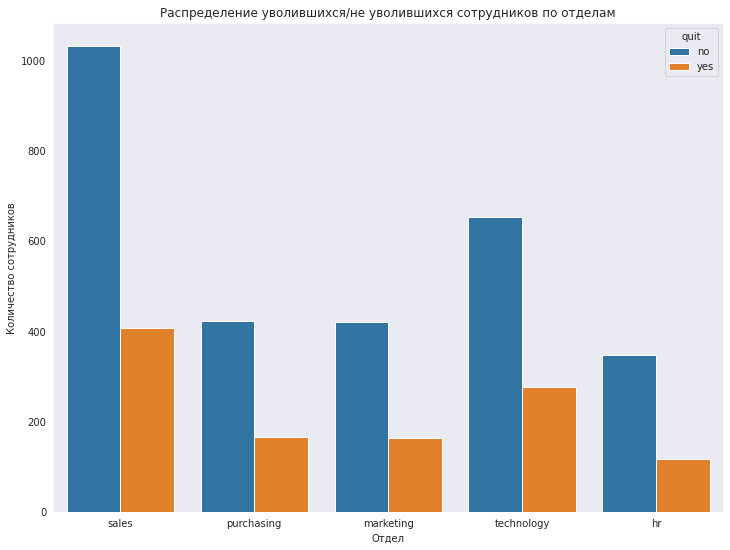

In [56]:
# построим распределение уволившихся/не уволившихся сотрудников по отделам
ax = sns.countplot(x=quit_X_train['dept'],hue=quit_X_train['quit'])
ax.set(title='Распределение уволившихся/не уволившихся сотрудников по отделам',
       xlabel='Отдел',
       ylabel='Количество сотрудников')
plt.show()

In [57]:
display(round(quit_X_train[quit_X_train['quit']=='yes']['dept'].value_counts()/
        quit_X_train['dept'].value_counts(),2)*100)

sales         28.0
technology    30.0
purchasing    28.0
marketing     28.0
hr            25.0
Name: dept, dtype: float64

Процент уволившихся сотрудников в каждом отделе приблизительно одинаковый - около 30%. Но лидер - технологический отдел.

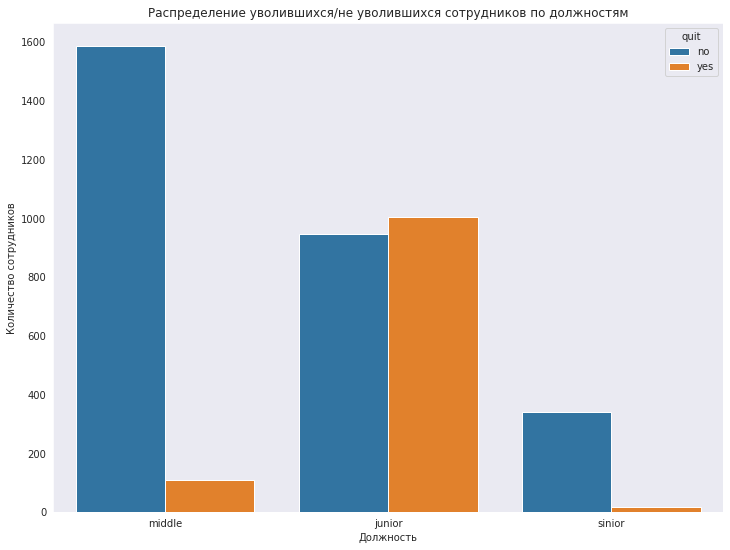

In [58]:
# построим распределение уволившихся/не уволившихся сотрудников по должностям
ax = sns.countplot(x=quit_X_train['level'],hue=quit_X_train['quit'])
ax.set(title='Распределение уволившихся/не уволившихся сотрудников по должностям',
       xlabel='Должность',
       ylabel='Количество сотрудников')
plt.show()

In [59]:
display(round(quit_X_train[quit_X_train['quit']=='yes']['level'].value_counts()/
        quit_X_train['level'].value_counts(),2)*100)

junior    51.0
middle     6.0
sinior     5.0
Name: level, dtype: float64

Самый высокий процент уволившихся сотрудников среди новичков - 51%, топ-менеджеры (5%) и мидлы (6%) редко увольняются 

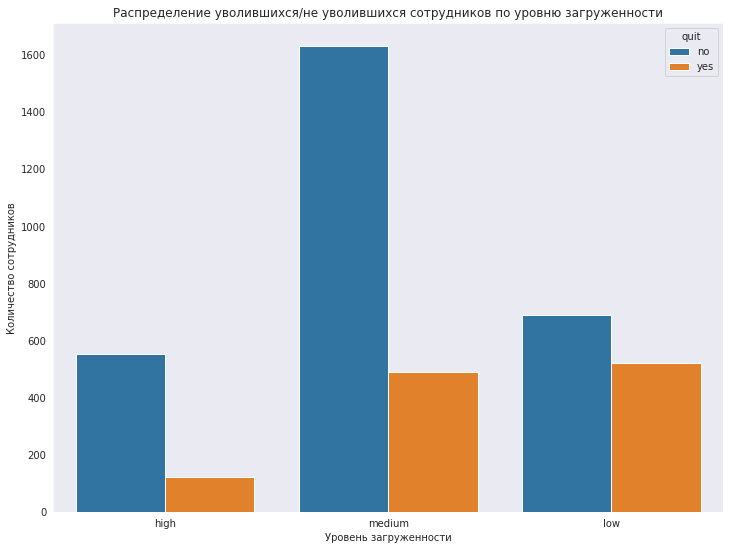

In [60]:
# построим распределение уволившихся/не уволившихся сотрудников по уровню загруженности
ax = sns.countplot(x=quit_X_train['workload'],hue=quit_X_train['quit'])
ax.set(title='Распределение уволившихся/не уволившихся сотрудников по уровню загруженности',
       xlabel='Уровень загруженности',
       ylabel='Количество сотрудников')
plt.show()

In [61]:
display(round(quit_X_train[quit_X_train['quit']=='yes']['workload'].value_counts()/
        quit_X_train['workload'].value_counts(),2)*100)

high      18.0
low       43.0
medium    23.0
Name: workload, dtype: float64

Чаще увольняются люди практически незагруженные  - 43%, люди со средней и высокой нагрузкой - более терпеливые.

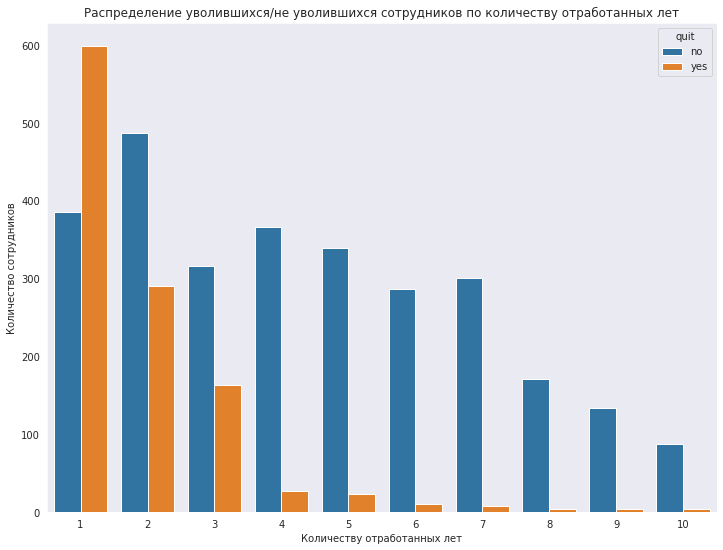

In [62]:
# построим распределение уволившихся/не уволившихся сотрудников по количеству отработанных лет
ax = sns.countplot(x=quit_X_train['employment_years'],hue=quit_X_train['quit'])
ax.set(title='Распределение уволившихся/не уволившихся сотрудников по количеству отработанных лет',
       xlabel='Количеству отработанных лет',
       ylabel='Количество сотрудников')
plt.show()

In [63]:
display(round(quit_X_train[quit_X_train['quit']=='yes']['employment_years'].value_counts()/
        quit_X_train['employment_years'].value_counts(),2)*100)

1     61.0
2     37.0
3     34.0
4      7.0
5      6.0
6      3.0
7      2.0
8      2.0
9      2.0
10     3.0
Name: employment_years, dtype: float64

Самый большой процент уволнений приходится на людей, отработавших 1 год - 61%,   

далее критичны 2-х и 3-х летний стаж - 37% и 34%. Люди, продержавшиеся 4 и более лет, также реже решаются сменить работу. 

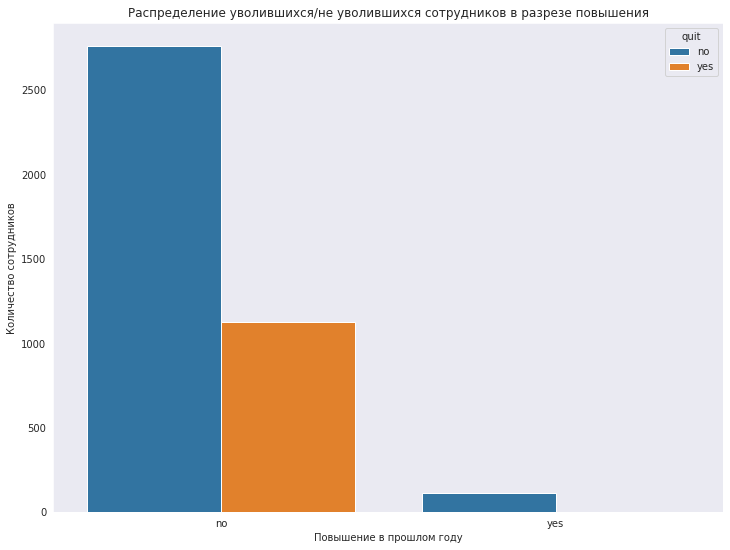

In [64]:
# построим распределение уволившихся/не уволившихся сотрудников в разрезе повышения
ax = sns.countplot(x=quit_X_train['last_year_promo'],hue=quit_X_train['quit'])
ax.set(title='Распределение уволившихся/не уволившихся сотрудников в разрезе повышения',
       xlabel='Повышение в прошлом году',
       ylabel='Количество сотрудников')
plt.show()

In [65]:
display(round(quit_X_train[quit_X_train['quit']=='yes']['last_year_promo'].value_counts()/
        quit_X_train['last_year_promo'].value_counts(),2)*100)

no     29.0
yes     1.0
Name: last_year_promo, dtype: float64

Похоже, что повышение положительно влияет на людей и они не склонны увольняться. Исключение составляет 1% от числа уволившихся.

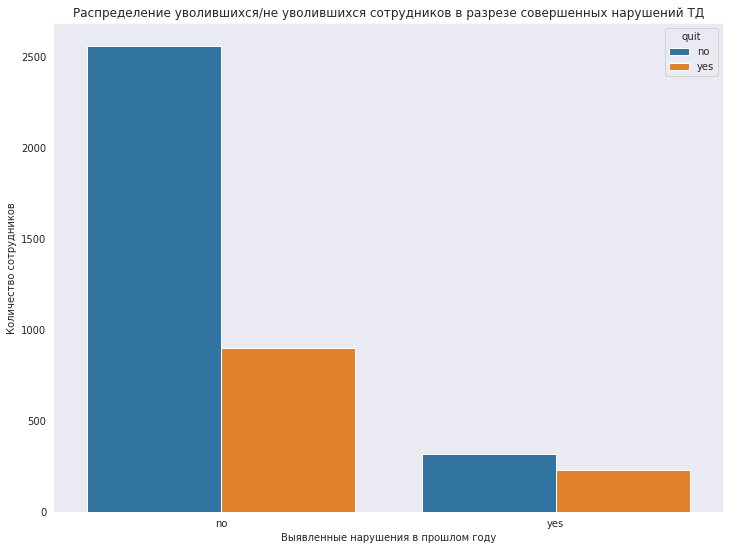

In [66]:
# построим распределение уволившихся/не уволившихся сотрудников в разрезе совершенных нарушений ТД
ax = sns.countplot(x=quit_X_train['last_year_violations'],hue=quit_X_train['quit'])
ax.set(title='Распределение уволившихся/не уволившихся сотрудников в разрезе совершенных нарушений ТД',
       xlabel='Выявленные нарушения в прошлом году',
       ylabel='Количество сотрудников')
plt.show()

In [67]:
display(round(quit_X_train[quit_X_train['quit']=='yes']['last_year_violations'].value_counts()/
        quit_X_train['last_year_violations'].value_counts(),2)*100)

no     26.0
yes    42.0
Name: last_year_violations, dtype: float64

Это выглядит естественным, что если к людям применяют наказание, то они хотят уволиться - 42%.

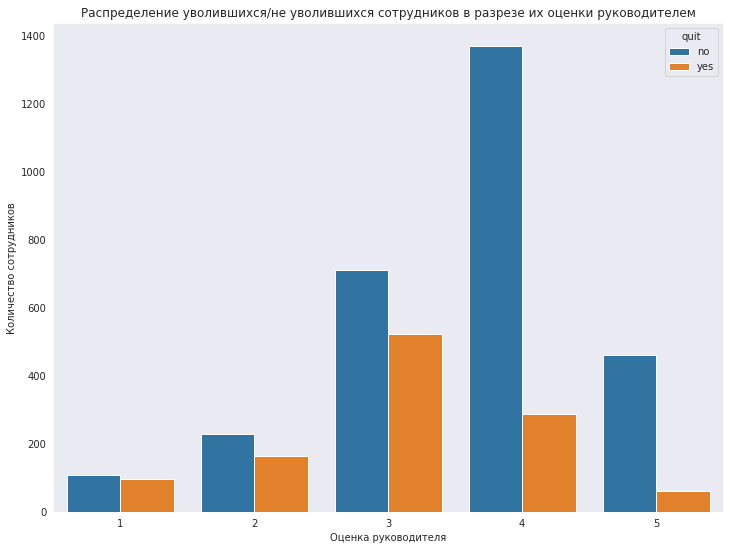

In [68]:
# построим распределение уволившихся/не уволившихся сотрудников в разрезе их оценки руководителем
ax = sns.countplot(x=quit_X_train['supervisor_evaluation'],hue=quit_X_train['quit'])
ax.set(title='Распределение уволившихся/не уволившихся сотрудников в разрезе их оценки руководителем',
       xlabel='Оценка руководителя',
       ylabel='Количество сотрудников')
plt.show()

In [69]:
display(round(quit_X_train[quit_X_train['quit']=='yes']['supervisor_evaluation'].value_counts()/
        quit_X_train['supervisor_evaluation'].value_counts(),2)*100)

1    47.0
2    42.0
3    42.0
4    17.0
5    12.0
Name: supervisor_evaluation, dtype: float64

Тут тоже картина объяснимая: если сотрудника ценят (высоко оценивают его вклад в общее дело), то он не будет думать об увольнении. Низкие оценки (1,2,3) мы видим чаще всего среди уволившихся.

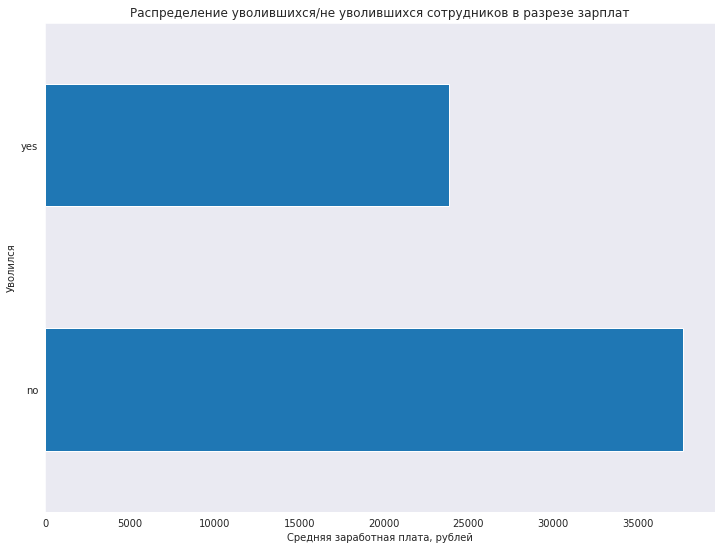

In [70]:
# построим распределение уволившихся/не уволившихся сотрудников в разрезе средней зарплаты
ax = quit_X_train.groupby('quit')['salary'].mean().plot(kind='barh')
ax.set(title='Распределение уволившихся/не уволившихся сотрудников в разрезе зарплат',
       xlabel='Средняя заработная плата, рублей',
       ylabel='Уволился')
plt.show()

In [71]:
display(round(quit_X_train['salary'][quit_X_train['quit'] == 'yes'].mean(),2))
display(round(quit_X_train['salary'][quit_X_train['quit'] == 'no'].mean(),2))
display(round((quit_X_train['salary'][quit_X_train['quit'] == 'yes'].mean())/
        (quit_X_train['salary'][quit_X_train['quit'] == 'no'].mean()),2)*100)

23885.11

37702.23

63.0

Средняя зарплата уволившихся меньше на 14'000 рублей и составляет 63% от средней зарплаты оставшихся сотрудников.

**Теперь можно составить итоговый портрет уволившегося:**
- работник любого отдела, но чаще всего технологического отдела,
- это новичок,
- средняя или низкая занятость,
- без повышения в прошлом году,
- с нарушениями трудового договора в прошлом году.   

Соотношение уволившихся и оставшихся сотрудников 1:3

Визуализируем и сравним распределения признака **job_satisfaction_rate** для ушедших и оставшихся сотрудников на тестовой выборке.

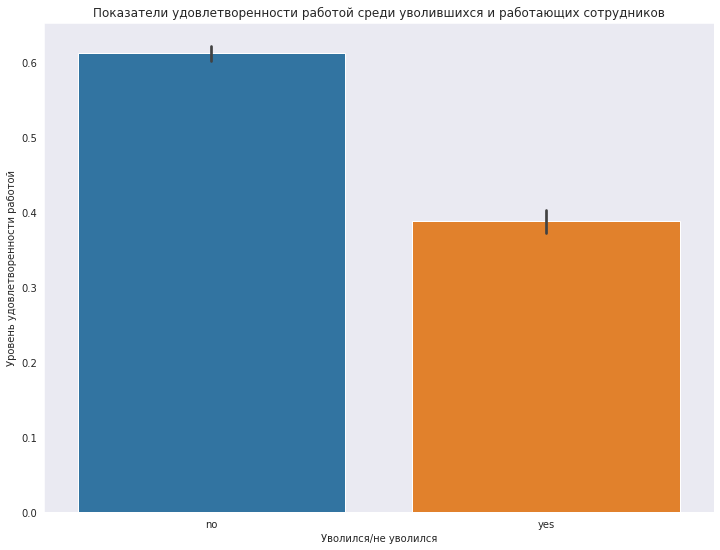

In [72]:
ax = sns.barplot(data=df_X_test.join(quit_y_test).join(df_y_test),
                x= df_X_test.join(quit_y_test).join(df_y_test)['quit'],
                y=df_X_test.join(quit_y_test).join(df_y_test)['job_satisfaction_rate'],
            )
ax.set_title('Показатели удовлетворенности работой среди уволившихся и работающих сотрудников')
ax.set_xlabel('Уволился/не уволился')
ax.set_ylabel('Уровень удовлетворенности работой')
plt.show()

Из графика видим, что у оставшихся в компании сотрудников удовлетворенность **выше = *0.6***.    
У уволившихся удовлетворенность **ниже = *0.4***.

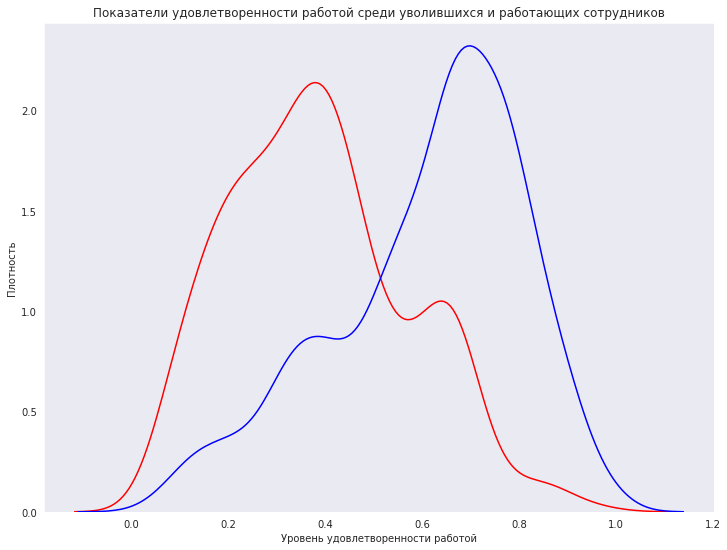

In [73]:
temp = df_test_merge.join(quit_y_test, on='id')
ax = sns.kdeplot(temp[temp['quit']=='yes']['job_satisfaction_rate'], color='red')
ax = sns.kdeplot(temp[temp['quit']=='no']['job_satisfaction_rate'], color='blue')
ax.set_title('Показатели удовлетворенности работой среди уволившихся и работающих сотрудников')
ax.set_xlabel('Уровень удовлетворенности работой')
ax.set_ylabel('Плотность')
plt.show()

**Вывод по результату исследовательского анализа**:     

Данные не содержат пропусков, дубликатов, аномалий. Наблюдается дисбаланс классов. Пропорции для целевого признака одинаковы дл тренировочно и тестовой выборок. 
    
Итоговый портрет уволившегося:
- чаще всего работник отдела продаж,
- это новичок,
- средняя или низкая занятость,
- без повышения в прошлом году,
- с предупреждениями в прошлом году.

# 2.4. Добавление нового входного признака

In [74]:
# объединим тестовые данные с целевым признаком по id
quit_X_test = df_test_merge.join(quit_y_test, on='id')

In [75]:
display(quit_X_test.head())

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate,quit
id,,,,,,,,,,
100298,hr,junior,low,2,no,no,4,19200,0.80,no
100480,marketing,junior,low,4,no,no,4,16800,0.84,no
100503,purchasing,middle,high,5,no,no,4,55200,0.79,no
100610,sales,middle,medium,5,no,no,4,43200,0.75,no
100692,sales,middle,high,6,no,no,4,48000,0.69,no


In [76]:
# рассчитаем признак job_satisfaction_rate и добавим его в тренировочную выборку, округлим значения до 2 знаков после запятой
quit_X_train['job_satisfaction_rate'] = randomized_search_rate.predict(quit_X_train.drop(['quit'], axis=1))
quit_X_train['job_satisfaction_rate'] = round(quit_X_train['job_satisfaction_rate'],2)
# проверим результат
display(quit_X_train.head())

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
id,,,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000,no,0.64
814010,sales,junior,medium,2,no,no,4,27600,no,0.82
155091,purchasing,middle,medium,5,no,no,1,37200,no,0.36
257132,sales,junior,medium,2,no,yes,3,24000,yes,0.38
910140,marketing,junior,medium,2,no,no,5,25200,no,0.69


# 2.5 Подготовка данных

Собираем пайплайн как и в первой задаче.

In [77]:
# задаем константу
RANDOM_STATE=42

# делим тренировочную и тестовую выборки на 2 датасета - входные признаки и целевой признак
X_train_q = quit_X_train.drop('quit', axis=1)
y_train_q = quit_X_train['quit']
X_test_q = quit_X_test.drop('quit', axis=1)
y_test_q = quit_X_test['quit']

In [78]:
# создадим экземпляр класса LabelEncoder для кодирования целевого признака
label_encoder = LabelEncoder()

# обучим модель и трансформируем тренировочную выборку
y_train_q = label_encoder.fit_transform(y_train_q)

# трансформируем тестовую выборку
y_test_q = label_encoder.transform(y_test_q)

In [79]:
# создаём списки с названиями признаков, используем 2 кодировщика
ohe_columns = ['dept','level','workload']
ord_columns = ['last_year_promo', 'last_year_violations']

In [80]:
# задаем числовые поля с дискретными и непрерывными значениями
num_columns = ['employment_years','supervisor_evaluation', 'salary', 'job_satisfaction_rate']

In [81]:
# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование
ohe_pipe = Pipeline(
    [
     ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False))
    ]
    )

In [82]:
# создаём пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков и Ordinal-кодирование
ord_pipe = Pipeline(
    [
     ('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories= [
                    ['no', 'yes'],
                    ['no', 'yes']
                ],
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

In [83]:
# создаём общий пайплайн для подготовки данных
data_preprocessor_q = ColumnTransformer(transformers=
    [('onehot', ohe_pipe, ohe_columns),
     ('ordinal', ord_pipe, ord_columns),
     ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

In [84]:
# создаём итоговый пайплайн: подготовка данных и модель
pipe_final_q = Pipeline([
    ('preprocessor', data_preprocessor_q),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

# 2.6 Обучение модели

Обучим 3 модели:
- DecisionTreeClassifier(),
- LogisticRegression(),
- KNeighborsClassifier().

In [85]:
# задаем словари с гиперпараметрами моделей
param_grid_q = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2,7),
        'models__max_features': range(2,7),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(5,15),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },
    
    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

Мы решаем задачу бинарной классификации, так что для оценки качества модели мы будем использовать оценку roc_auc.

In [86]:
# запускаем поиск лучшей модели и ее параметров и обучаем ее на тренировочной выборке
randomized_search_q = RandomizedSearchCV(
    pipe_final_q, 
    param_grid_q, 
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

In [87]:
randomized_search_q.fit(X_train_q, y_train_q)

rs_q = randomized_search_q.best_estimator_

In [88]:
# выводим на экран параметры лучшей модели
print('Лучшая модель и её параметры:\n\n', randomized_search_q.best_estimator_)
print (f'Метрика roc_auc лучшей модели, полученная кросс-валидацией: {randomized_search_q.best_score_: .2f}')

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehot',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['dept', 'level',
                                                   'workload']),
                                                 ('ordinal',
                                                  

Значение метрики хорошее **roc_auc = 0.93**    
Параметры лучшей модели: LogisticRegression(C=3, penalty='l1', random_state=42, solver='liblinear')

In [89]:
# проверяем работу модели на тестовой выборке
# рассчитываем прогноз на тестовых данных
y_test_pred_q = randomized_search_q.predict(X_test_q)

# рассчитываем вероятности для тестовых данных
y_test_proba_q = randomized_search_q.predict_proba(X_test_q)[:,1]

# выводим значение метрики roc-auc для тестовых данных
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test_q, y_test_proba_q): .2f}')

Метрика ROC-AUC на тестовой выборке:  0.93


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [90]:
# рассчитаем f1-метрику
print(f'Метрика F1-score на тестовой выборке: {f1_score(y_test_q, y_test_pred_q, average="macro"): .2f}')

Метрика F1-score на тестовой выборке:  0.89


Проверим модель на адекватность путем расчета метрики roc_auc на не обработанных данных

In [91]:
# строим модель на тренировочной выборке
dummy_model_q = DummyClassifier(random_state=RANDOM_STATE)
dummy_model_q = dummy_model_q.fit(X_train_q, y_train_q)

# выполним предсказание на тестовой выборке и рассчитаем вероятности предсказаний
dummy_model_preds_q = dummy_model_q.predict(X_test_q)
dummy_model_probas_q = dummy_model_q.predict_proba(X_test_q)[:,1]

# подсчитаем метрику ROC-AUC
dummy_roc_q = roc_auc_score(y_test_q,dummy_model_probas_q)
print('ROC-AUC =', round(dummy_roc_q,2))

ROC-AUC = 0.5


Все было не зря, обученная модель показывает результаты гораздо выше.   

Оценим важность признаков в модели

In [92]:
# формируем тренировочную выборку, используя полученную модель
X_train_new_q = data_preprocessor_q.fit_transform(X_train_q)

# формируем тестовую выборку, используя полученную модель
X_test_new_q = data_preprocessor_q.transform(X_test_q)

# Создаем массив новых имен столбцов
feature_names_q = data_preprocessor_q.get_feature_names_out()

# Фильтруем датафрейм по списку полей, полученных после кодирования
X_test_new_q = pd.DataFrame(X_test_new_q, columns=feature_names_q)

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [93]:
# инициализируем селектор и модель
selector_q = SelectKBest(f_classif)

# обучим SelectKBest
selector_q.fit(X_train_new_q, y_train_q)

SelectKBest()

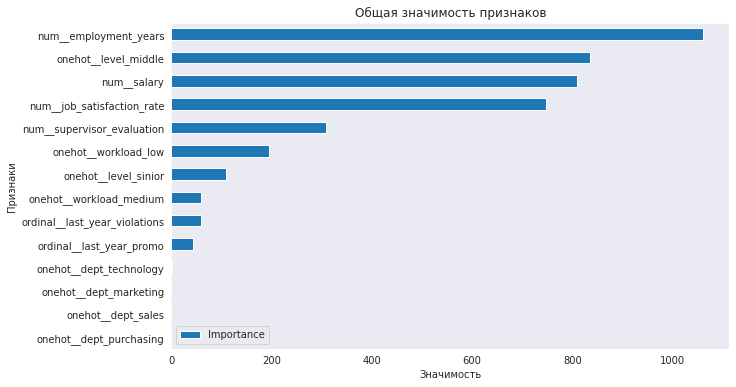

In [94]:
# отложим значения оценок для каждого признака на графике
feature_importance = pd.DataFrame({'Feature': feature_names_q, 'Importance': selector_q.scores_})
feature_importance = feature_importance.sort_values('Importance', ascending= True)
ax = sns.set_style('dark')
ax = feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6))
ax.set_title("Общая значимость признаков")
ax.set_xlabel("Значимость")
ax.set_ylabel("Признаки")
plt.show()

В отличие от показателя удовлетворенности на предсказание увольнения влияет много входных признаков.    
Наибольшее влияние имеют:
- количество отработанных лет,
- занимаемая должность,
- зарплата,
- уровень удовлетворенности работой.   


# 2.7 Выводы

Перед нами стояло 2 задачи:    
- определить уровень удовлетворенности сотрудников работой,
- построить модель для предсказания увольнения сотрудников.

Для решения 1-й задачи мы собрали пайплайн, в котором закодировали входные признаки, выбрали подходящие под условия задачи модели и задали им параметры. Были выбраны модель линейной регрессии и дерево решений. В качестве метрики, которая определяла качество модели, была выбрана SMAPE. В ходе обучения модели мы меняли гиперпараметры модели дерева решений, в результате чего построили модель, которая дала оценку 15.07 на тренировочной выборке и 14.48 - на тестовой при пороге <=15.   

Лучшей моделью оказалось дерево решений, поскольку модель определяет мультиклассовую классификацию для целевого признака.   

По результатам анализа важности признаков для модели мы определили, что их всего 2:   
- supervisor_evaluation — оценка качества работы сотрудника руководителем,
- last_year_violations - нарушал ли сотрудник трудовой договор за последний год.

Исходя из предпосылки, что уровень удовлетворенности сотрудников работой влияет на решение об увольнении, мы добавили в иcходные данные (тренировочные) для решения второй задачи столбец, полученный первой моделью, с данными об удовлетворенности сотрудников. Также собрали пайплайн для поиска лучшей модели. В качестве метрики выбрали roc_auc, поскольку перед нами стояла задача бинарной классификации (уволится/не уволится). Рассматривали 3 модели: дерево решений, логистическую регрессию и метод поиска ближайшего соседа.    

Лучше всех себя показала модель логистической регрессии. Метрика roc_auc=0.93 на тренировочных данных и 0.93 - на тестовых.

По результатам анализа важности признаков для модели мы определили, что их 4:   
- количество отработанных лет,
- занимаемая должность,
- зарплата,
- уровень удовлетворенности работой.

Рекомендации, которые мы дадим бизнесу, - это портрет человека, который готов потенциально уволиться.

Пристально нужно следить за новыми сотрудниками отдела продаж со средним или низким уровнем занятости, у которых есть предупреждения и которых не повышают.
Кроме того, полезная практика - проводить опросы удовлетворенности сотрудников работой для своевременного выявления желающих уволиться сотрудников.